# Introduction

This notebook contains code for a homework assignment on text classification of news articles into 5 categories.
It explores different feature engineering methods, trains neural network models using 5-fold cross validation,
and evaluates performance. The best model is then used to predict labels on a test set.




# 1.   Imports and Setup



In [1]:
!pip install rake-nltk



*   Import required libraries
*   Mount Google Drive
*   download nltk packages











In [2]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import random
from tqdm import tqdm
import pandas as pd
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import gensim.downloader as api
import gensim


Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loading training and test data into panda dataframe 🐼

# Part 1 Data Loading and Preprocessing -

**Question 1 Preprocess the raw training data. You can use the code from Homework 1. You are required to construct other features, such n-grams or keyword extractions. (15pt)**

* Load train and test CSV files
* Explore data
* Define and apply text preprocessing function



In [3]:

train_data_path = '/content/drive/MyDrive/Colab Notebooks/Homework2/24_train_1.csv'
test_data_path = '/content/drive/MyDrive/Colab Notebooks/Homework2/news-test.csv'
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)


In [4]:
print(train_data)
print(train_data.info())
print(train_data['Category'])


     ArticleId                                               Text  \
0         1429  sfa awaits report over mikoliunas the scottish...   
1         1896  parmalat to return to stockmarket parmalat  th...   
2         1633  edu blasts arsenal arsenal s brazilian midfiel...   
3         2178  henman decides to quit davis cup tim henman ha...   
4          194  french suitor holds lse meeting european stock...   
..         ...                                                ...   
995       1250  blair  damaged  by blunkett row a majority of ...   
996       1639  a november to remember last saturday  one news...   
997        916  highbury tunnel players in clear the football ...   
998       2217  top stars join us tsunami tv show brad pitt  r...   
999        902  eastwood s baby scoops top oscars clint eastwo...   

          Category  
0            sport  
1         business  
2            sport  
3            sport  
4         business  
..             ...  
995       politics  
996

**Question 1.a: Run Neural Networks with the 2-hidden layers, each has 128 neurons, extracting features by CountVectorizer() as the original features. Use 5-fold cross-validation to evaluate the performance.**

This section loads the raw training and test data from CSV files into Pandas dataframes.
It then preprocesses the text by:
* Tokenizing
* Lowercasing
* Removing punctuation
* Removing non-alphabetic tokens
* Removing stopwords
* Stemming


The preprocessed text is added as a new column in the dataframes.

It then extracts CountVectorizer features and runs a 2-layer neural network with 5-fold cross validation.

In [5]:
# Preprocessing function
def preprocess_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Lowercasing
    tokens = [w.lower() for w in tokens]

    # Removing punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    # Removing non-alphabetic tokens
    words = [word for word in stripped if word.isalpha()]

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    # Stemming
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]

    return ' '.join(stemmed)

# Apply preprocessing to training and test data
train_data['Processed_Text'] = train_data['Text'].apply(preprocess_text)
test_data['Processed_Text'] = test_data['Text'].apply(preprocess_text)


# Feature Engineering

**Question 1.b:  Feature exploration. Use other features like TFIDF, or any word embeddings provided by other packages like GloVe with gensim, or BERT. Use 5-fold cross-validation to evaluate the performance of your Neural Network.**
* This section generates various features from the preprocessed text:
* N-grams (bigrams)
* TF-IDF vectors
* GloVe word embeddings (averaging word vectors for each document)
*  Word2Vec embeddings (training a Word2Vec model on the corpus and averaging word vectors for each document)


In [6]:

# Create n-grams
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.split(" ") if token != "" if token not in stopwords.words('english')]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Generate n-grams for training data
train_data['Processed_Text_ngrams'] = train_data['Processed_Text'].apply(lambda x: generate_ngrams(x, n_gram=2))

# Generate n-grams for test data
test_data['Processed_Text_ngrams'] = test_data['Processed_Text'].apply(lambda x: generate_ngrams(x, n_gram=2))


In [7]:
# Load GloVe embeddings
glove_vectors = api.load("glove-twitter-100")
glove_embeddings = []

for doc in train_data['Processed_Text_ngrams']:
    doc_embedding = []
    for word in doc:
        if word in glove_vectors:
            doc_embedding.append(glove_vectors[word])
    if doc_embedding:
        doc_embedding = np.mean(doc_embedding, axis=0)
    else:
        doc_embedding = np.zeros(100)
    glove_embeddings.append(doc_embedding)

glove_embeddings = np.array(glove_embeddings)

# Create TF-IDF features
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tfidf.fit_transform(train_data['Processed_Text_ngrams'].apply(lambda x: ' '.join(x)))
tfidf_test = tfidf.transform(test_data['Processed_Text_ngrams'].apply(lambda x: ' '.join(x)))

# Train Word2Vec model
w2v_model = gensim.models.Word2Vec(train_data['Processed_Text_ngrams'], vector_size=100, window=5, min_count=1, workers=4)
w2v_embeddings = []
for doc in train_data['Processed_Text_ngrams']:
    doc_embedding = []
    for word in doc:
        if word in w2v_model.wv:
            doc_embedding.append(w2v_model.wv[word])
    if doc_embedding:
        doc_embedding = np.mean(doc_embedding, axis=0)
    else:
        doc_embedding = np.zeros(100)
    w2v_embeddings.append(doc_embedding)

w2v_embeddings = np.array(w2v_embeddings)

[==================================================] 100.0% 387.1/387.1MB downloaded


**Question 1.c. Describe how you generate features. (5pt)**

The features are generated as follows:
* CountVectorizer: Counts the frequency of each word in each document
* N-grams: Generates bigrams from the preprocessed text
* TF-IDF: Computes TF-IDF weights for each word in each document
* GloVe: Averages the pre-trained GloVe embeddings for each word in a document to get a document embedding
Word2Vec: Trains a Word2Vec model on the corpus and averages the learned word embeddings for each document


# Model Definition
This section defines the architecture of the neural network model (NewsClassifier) using PyTorch.
The model has an embedding layer, two hidden layers with ReLU activation, and a softmax output layer.
The forward pass of the model is defined in the forward() method.

In [8]:

# Define neural network model
class NewsClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(NewsClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out


In [9]:

# Define training function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

# Define evaluation function
def eval_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    print(f"Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc


In [10]:
# Define dataset class
class NewsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)  # Convert features to float32
        self.labels = torch.tensor(labels, dtype=torch.long)  # Labels should be of type long for classification

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# Define function to run 5-fold cross-validation
def run_cross_validation(model, features, labels, batch_size, num_epochs, device):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    train_accuracies = []
    val_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(features)):
        print(f"Fold {fold+1}")
        train_dataset = NewsDataset(features[train_idx], labels[train_idx])
        val_dataset = NewsDataset(features[val_idx], labels[val_idx])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        model = NewsClassifier(features.shape[1], 128, len(np.unique(labels))).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())

        for epoch in range(num_epochs):
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = eval_model(model, val_loader, criterion, device)
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        train_accuracies.append(train_acc.cpu().numpy())
        val_accuracies.append(val_acc.cpu().numpy())

    return np.mean(train_accuracies), np.std(train_accuracies), np.mean(val_accuracies), np.std(val_accuracies)

# Convert labels to numerical values
label_map = {'sport': 0, 'business': 1, 'politics': 2, 'entertainment': 3, 'tech': 4}
train_labels = train_data['Category'].map(label_map).values
#test_labels = test_data['Category'].map(label_map).values


# Model Training with Cross Validation
* This section defines functions for training (train_model) and evaluating (eval_model) the neural network model.
* It also defines a custom Dataset class (NewsDataset) for loading the features and labels.
The run_cross_validation function performs 5-fold cross validation with a given feature set.
* It trains the model on the training set and evaluates on the validation set for each fold.
* It returns the average training and validation accuracies and their standard deviations.
* Cross validation is run with CountVectorizer, TF-IDF, GloVe, and Word2Vec features.
The results are printed in a table and visualized in a bar chart.

In [11]:

# Run cross-validation with CountVectorizer features
print("Running cross-validation with CountVectorizer features...")
vectorizer = CountVectorizer()
count_train = vectorizer.fit_transform(train_data['Processed_Text']).toarray()
count_test = vectorizer.transform(test_data['Processed_Text']).toarray()
count_train_acc, count_train_std, count_val_acc, count_val_std = run_cross_validation(NewsClassifier, count_train, train_labels, batch_size=32, num_epochs=10, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


Running cross-validation with CountVectorizer features...
Fold 1
Training Loss: 0.9579, Training Accuracy: 0.8187
Validation Loss: 0.2240, Validation Accuracy: 0.9600
Epoch 1/10 - Train Loss: 0.9579, Train Acc: 0.8187, Val Loss: 0.2240, Val Acc: 0.9600
Training Loss: 0.0395, Training Accuracy: 0.9975
Validation Loss: 0.1862, Validation Accuracy: 0.9700
Epoch 2/10 - Train Loss: 0.0395, Train Acc: 0.9975, Val Loss: 0.1862, Val Acc: 0.9700
Training Loss: 0.0023, Training Accuracy: 1.0000
Validation Loss: 0.1902, Validation Accuracy: 0.9750
Epoch 3/10 - Train Loss: 0.0023, Train Acc: 1.0000, Val Loss: 0.1902, Val Acc: 0.9750
Training Loss: 0.0011, Training Accuracy: 1.0000
Validation Loss: 0.1749, Validation Accuracy: 0.9700
Epoch 4/10 - Train Loss: 0.0011, Train Acc: 1.0000, Val Loss: 0.1749, Val Acc: 0.9700
Training Loss: 0.0008, Training Accuracy: 1.0000
Validation Loss: 0.1771, Validation Accuracy: 0.9650
Epoch 5/10 - Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.1771, Val Acc: 0.

In [12]:

# Run cross-validation with TF-IDF features
print("Running cross-validation with TF-IDF features...")
tfidf_train_acc, tfidf_train_std, tfidf_val_acc, tfidf_val_std = run_cross_validation(NewsClassifier, tfidf_train.toarray(), train_labels, batch_size=32, num_epochs=10, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


Running cross-validation with TF-IDF features...
Fold 1
Training Loss: 1.5517, Training Accuracy: 0.5350
Validation Loss: 1.4047, Validation Accuracy: 0.8600
Epoch 1/10 - Train Loss: 1.5517, Train Acc: 0.5350, Val Loss: 1.4047, Val Acc: 0.8600
Training Loss: 0.9412, Training Accuracy: 0.9875
Validation Loss: 0.6729, Validation Accuracy: 0.9450
Epoch 2/10 - Train Loss: 0.9412, Train Acc: 0.9875, Val Loss: 0.6729, Val Acc: 0.9450
Training Loss: 0.1432, Training Accuracy: 1.0000
Validation Loss: 0.2474, Validation Accuracy: 0.9700
Epoch 3/10 - Train Loss: 0.1432, Train Acc: 1.0000, Val Loss: 0.2474, Val Acc: 0.9700
Training Loss: 0.0104, Training Accuracy: 1.0000
Validation Loss: 0.1783, Validation Accuracy: 0.9700
Epoch 4/10 - Train Loss: 0.0104, Train Acc: 1.0000, Val Loss: 0.1783, Val Acc: 0.9700
Training Loss: 0.0036, Training Accuracy: 1.0000
Validation Loss: 0.1604, Validation Accuracy: 0.9750
Epoch 5/10 - Train Loss: 0.0036, Train Acc: 1.0000, Val Loss: 0.1604, Val Acc: 0.9750
Trai

In [13]:

# Run cross-validation with GloVe embeddings
print("Running cross-validation with GloVe embeddings...")
glove_train_acc, glove_train_std, glove_val_acc, glove_val_std = run_cross_validation(NewsClassifier, glove_embeddings, train_labels, batch_size=32, num_epochs=10, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


Running cross-validation with GloVe embeddings...
Fold 1
Training Loss: 1.6081, Training Accuracy: 0.2063
Validation Loss: 1.6020, Validation Accuracy: 0.2450
Epoch 1/10 - Train Loss: 1.6081, Train Acc: 0.2063, Val Loss: 1.6020, Val Acc: 0.2450
Training Loss: 1.6055, Training Accuracy: 0.2275
Validation Loss: 1.6014, Validation Accuracy: 0.2450
Epoch 2/10 - Train Loss: 1.6055, Train Acc: 0.2275, Val Loss: 1.6014, Val Acc: 0.2450
Training Loss: 1.6052, Training Accuracy: 0.2200
Validation Loss: 1.6016, Validation Accuracy: 0.2200
Epoch 3/10 - Train Loss: 1.6052, Train Acc: 0.2200, Val Loss: 1.6016, Val Acc: 0.2200
Training Loss: 1.6050, Training Accuracy: 0.2225
Validation Loss: 1.6006, Validation Accuracy: 0.2450
Epoch 4/10 - Train Loss: 1.6050, Train Acc: 0.2225, Val Loss: 1.6006, Val Acc: 0.2450
Training Loss: 1.6055, Training Accuracy: 0.2063
Validation Loss: 1.6014, Validation Accuracy: 0.2450
Epoch 5/10 - Train Loss: 1.6055, Train Acc: 0.2063, Val Loss: 1.6014, Val Acc: 0.2450
Tra

In [14]:

# Run cross-validation with Word2Vec embeddings
print("Running cross-validation with Word2Vec embeddings...")
w2v_train_acc, w2v_train_std, w2v_val_acc, w2v_val_std = run_cross_validation(NewsClassifier, w2v_embeddings, train_labels, batch_size=32, num_epochs=10,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


Running cross-validation with Word2Vec embeddings...
Fold 1
Training Loss: 1.6076, Training Accuracy: 0.2100
Validation Loss: 1.6030, Validation Accuracy: 0.2450
Epoch 1/10 - Train Loss: 1.6076, Train Acc: 0.2100, Val Loss: 1.6030, Val Acc: 0.2450
Training Loss: 1.6057, Training Accuracy: 0.2275
Validation Loss: 1.6023, Validation Accuracy: 0.2450
Epoch 2/10 - Train Loss: 1.6057, Train Acc: 0.2275, Val Loss: 1.6023, Val Acc: 0.2450
Training Loss: 1.6055, Training Accuracy: 0.2275
Validation Loss: 1.6013, Validation Accuracy: 0.2450
Epoch 3/10 - Train Loss: 1.6055, Train Acc: 0.2275, Val Loss: 1.6013, Val Acc: 0.2450
Training Loss: 1.6050, Training Accuracy: 0.2275
Validation Loss: 1.6008, Validation Accuracy: 0.2450
Epoch 4/10 - Train Loss: 1.6050, Train Acc: 0.2275, Val Loss: 1.6008, Val Acc: 0.2450
Training Loss: 1.6052, Training Accuracy: 0.2275
Validation Loss: 1.6012, Validation Accuracy: 0.2450
Epoch 5/10 - Train Loss: 1.6052, Train Acc: 0.2275, Val Loss: 1.6012, Val Acc: 0.2450


**Question 1.d: Report the average training and validation accuracy, and their standard deviation for different feature construction (organize the results in a table). (5pt)**

* The run_cross_validation function performs 5-fold cross validation with a given feature set and reports the average training and validation accuracies along with standard deviations.
* The results for each feature set are printed in a table.

In [15]:

# Print results table
print("Results Table:")
print("Feature Method\tTrain Accuracy\tTrain Std\tVal Accuracy\tVal Std")
print(f"CountVectorizer\t{count_train_acc:.3f}\t{count_train_std:.3f}\t{count_val_acc:.3f}\t{count_val_std:.3f}")
print(f"TF-IDF\t{tfidf_train_acc:.3f}\t{tfidf_train_std:.3f}\t{tfidf_val_acc:.3f}\t{tfidf_val_std:.3f}")
print(f"GloVe\t{glove_train_acc:.3f}\t{glove_train_std:.3f}\t{glove_val_acc:.3f}\t{glove_val_std:.3f}")
print(f"Word2Vec\t{w2v_train_acc:.3f}\t{w2v_train_std:.3f}\t{w2v_val_acc:.3f}\t{w2v_val_std:.3f}")


Results Table:
Feature Method	Train Accuracy	Train Std	Val Accuracy	Val Std
CountVectorizer	1.000	0.000	0.967	0.011
TF-IDF	1.000	0.000	0.975	0.013
GloVe	0.229	0.010	0.217	0.026
Word2Vec	0.225	0.012	0.209	0.020


**Question 1.e. Draw a bar figure showing the training and validation result, x-axis should be the parameter values, y-axis should be the training and validation accuracy. (5pt)**

* This code plots a bar chart comparing the training and validation accuracies for each feature engineering method.
* The x-axis shows the different methods, while the y-axis shows the accuracy scores.


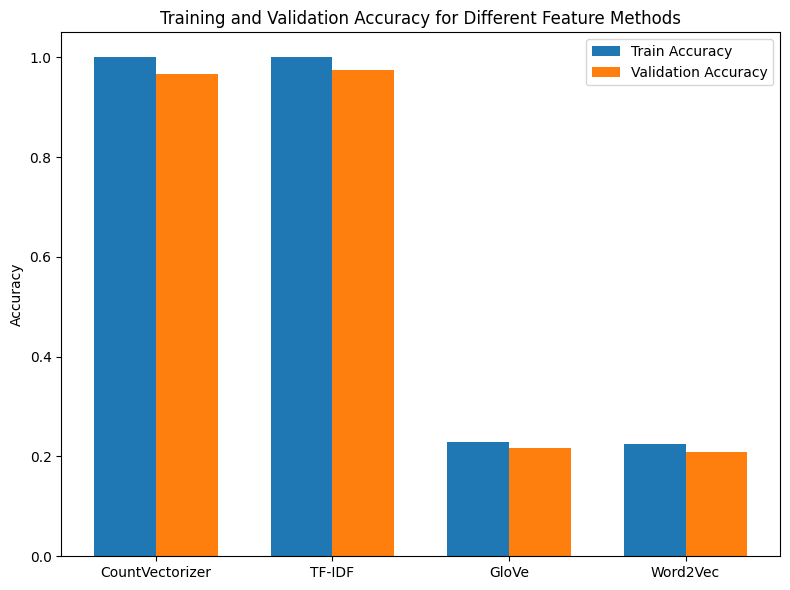

In [16]:
# Define the list of feature methods
feature_methods = ['CountVectorizer', 'TF-IDF', 'GloVe', 'Word2Vec']

# Assuming you have the corresponding accuracy values in the following lists
train_accuracies = [count_train_acc, tfidf_train_acc, glove_train_acc, w2v_train_acc]
val_accuracies = [count_val_acc, tfidf_val_acc, glove_val_acc, w2v_val_acc]

x = np.arange(len(feature_methods))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
ax.bar(x + width/2, val_accuracies, width, label='Validation Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy for Different Feature Methods')
ax.set_xticks(x)
ax.set_xticklabels(feature_methods)
ax.legend()

plt.tight_layout()
plt.show()


# Part 2. Explore the Neural Network model on pre-processed training data. (25pt)

# Learning Rate Experiments

**Question 2.a : Describe your parameter setting. (5pt)**
This section explores the impact of different learning rates on model performance using 5-fold cross validation.
The learning rates to try are defined in the learning_rates list.
The run_cross_validation_lr function trains and evaluates the model with each learning rate.
The results are printed in a table and visualized in a line chart of accuracy vs learning rate.


* Parameter Settings for Learning Rate Experimentation
* Neural Network Architecture: 2 hidden layers with 128 neurons each
* Activation Function: ReLU
* Output Layer: Softmax (implicitly applied with CrossEntropyLoss)
* Loss Function: CrossEntropyLoss
* Batch Size: 32
* Number of Epochs: 10 (or more, depending on convergence)
* Learning Rates to Explore: [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]

In [17]:
def run_cross_validation_lr(model_class, features, labels, batch_size, num_epochs, device, learning_rates):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for lr in learning_rates:
        print(f"Learning Rate: {lr}")
        train_accuracies = []
        val_accuracies = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(features)):
            print(f"Fold {fold+1}")
            train_dataset = NewsDataset(features[train_idx], labels[train_idx])
            val_dataset = NewsDataset(features[val_idx], labels[val_idx])

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size)

            model = model_class(features.shape[1], 128, len(np.unique(labels))).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            for epoch in range(num_epochs):
                train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
                val_loss, val_acc = eval_model(model, val_loader, criterion, device)

            train_accuracies.append(train_acc.item())
            val_accuracies.append(val_acc.item())

        results.append({
            'lr': lr,
            'train_acc_mean': np.mean(train_accuracies),
            'train_acc_std': np.std(train_accuracies),
            'val_acc_mean': np.mean(val_accuracies),
            'val_acc_std': np.std(val_accuracies),
        })

    return results


**Question 2.b: Use 5-fold cross-validation to evaluate the performance w.r.t. the learning rates (η), you could use the feature engineering method that has the best performance from Question 1. Recommended candidate values: [0.0001,0.0003,0.001,0.003,0.01,0.03,0.1]**

This section runs 5-fold cross validation with different learning rates to find the optimal value.
It uses the best performing feature set from Question 1, that is TFIDF.
The run_cross_validation_lr function trains and evaluates the model with each learning rate.
The results are reported in a table and visualized in a line plot of accuracy vs learning rate.

In [18]:
# Define the learning rates to explore
learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]

# Run the cross-validation for each learning rate
lr_results = run_cross_validation_lr(NewsClassifier, tfidf_train.toarray(), train_labels, batch_size=32, num_epochs=10, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), learning_rates=learning_rates)

# Organize the results in a table
print("Learning Rate\tTrain Accuracy\tTrain Std\tValidation Accuracy\tValidation Std")
for result in lr_results:
    print(f"{result['lr']}\t{result['train_acc_mean']:.3f}\t{result['train_acc_std']:.3f}\t{result['val_acc_mean']:.3f}\t{result['val_acc_std']:.3f}")


Learning Rate: 0.0001
Fold 1
Training Loss: 1.6071, Training Accuracy: 0.2275
Validation Loss: 1.6020, Validation Accuracy: 0.2450
Training Loss: 1.5921, Training Accuracy: 0.2275
Validation Loss: 1.5884, Validation Accuracy: 0.2450
Training Loss: 1.5673, Training Accuracy: 0.3563
Validation Loss: 1.5683, Validation Accuracy: 0.3600
Training Loss: 1.5313, Training Accuracy: 0.6613
Validation Loss: 1.5410, Validation Accuracy: 0.5200
Training Loss: 1.4832, Training Accuracy: 0.9637
Validation Loss: 1.5046, Validation Accuracy: 0.7600
Training Loss: 1.4174, Training Accuracy: 0.9988
Validation Loss: 1.4541, Validation Accuracy: 0.8500
Training Loss: 1.3274, Training Accuracy: 1.0000
Validation Loss: 1.3880, Validation Accuracy: 0.9050
Training Loss: 1.2115, Training Accuracy: 1.0000
Validation Loss: 1.3043, Validation Accuracy: 0.9250
Training Loss: 1.0729, Training Accuracy: 1.0000
Validation Loss: 1.2072, Validation Accuracy: 0.9400
Training Loss: 0.9179, Training Accuracy: 1.0000
Vali

* Visualize accuracy vs learning rate

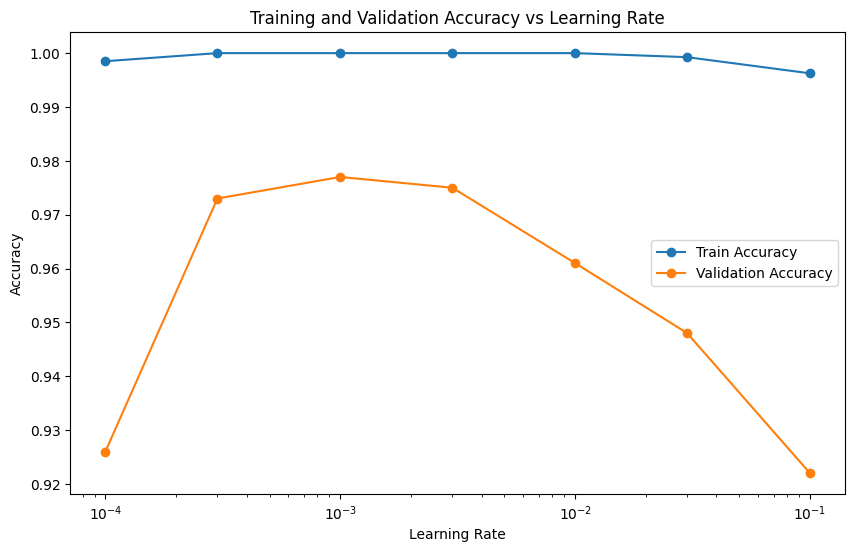

In [19]:
# Extract learning rates and accuracies for plotting
lrs = [result['lr'] for result in lr_results]
train_accs = [result['train_acc_mean'] for result in lr_results]
val_accs = [result['val_acc_mean'] for result in lr_results]

plt.figure(figsize=(10, 6))
plt.plot(lrs, train_accs, label='Train Accuracy', marker='o')
plt.plot(lrs, val_accs, label='Validation Accuracy', marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Learning Rate')
plt.legend()
plt.show()


# Optimizer Experiments

**Question 2.C: Use 5-fold cross-validation to evaluate the performance w.r.t. optimizers, you could use the feature engineering method that has the best performance from Question 1.**

* This section compares the performance of different optimizers (SGD, Adam, RMSprop) using 5-fold cross validation.
* The run_cross_validation_optimizer function trains and evaluates the model with each optimizer.
* The results are printed in a table and visualized in a bar chart of train and validation accuracy for each optimizer.




In [20]:
def run_cross_validation_optimizer(model_class, features, labels, batch_size, num_epochs, device, optimizers):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for opt_name, opt_func in optimizers.items():
        print(f"Optimizer: {opt_name}")
        train_accuracies = []
        val_accuracies = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(features)):
            print(f"Fold {fold+1}")
            train_dataset = NewsDataset(features[train_idx], labels[train_idx])
            val_dataset = NewsDataset(features[val_idx], labels[val_idx])

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size)

            model = model_class(features.shape[1], 128, len(np.unique(labels))).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = opt_func(model.parameters())

            for epoch in range(num_epochs):
                train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
                val_loss, val_acc = eval_model(model, val_loader, criterion, device)

            train_accuracies.append(train_acc.item())
            val_accuracies.append(val_acc.item())

        results.append({
            'optimizer': opt_name,
            'train_acc_mean': np.mean(train_accuracies),
            'train_acc_std': np.std(train_accuracies),
            'val_acc_mean': np.mean(val_accuracies),
            'val_acc_std': np.std(val_accuracies),
        })

    return results


In [21]:
# Define the optimizers to explore
optimizers = {
    'SGD': lambda params: optim.SGD(params, lr=0.001),
    'Adam': lambda params: optim.Adam(params, lr=0.001),
    'RMSprop': lambda params: optim.RMSprop(params, lr=0.001),
}

# Run the cross-validation for each optimizer
opt_results = run_cross_validation_optimizer(NewsClassifier, tfidf_train.toarray(), train_labels, batch_size=32, num_epochs=10, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), optimizers=optimizers)

# Organize the results in a table
print("Optimizer\tTrain Accuracy\tTrain Std\tValidation Accuracy\tValidation Std")
for result in opt_results:
    print(f"{result['optimizer']}\t{result['train_acc_mean']:.3f}\t{result['train_acc_std']:.3f}\t{result['val_acc_mean']:.3f}\t{result['val_acc_std']:.3f}")


Optimizer: SGD
Fold 1
Training Loss: 1.6095, Training Accuracy: 0.1825
Validation Loss: 1.6084, Validation Accuracy: 0.1900
Training Loss: 1.6094, Training Accuracy: 0.1825
Validation Loss: 1.6083, Validation Accuracy: 0.1900
Training Loss: 1.6094, Training Accuracy: 0.1825
Validation Loss: 1.6082, Validation Accuracy: 0.1900
Training Loss: 1.6093, Training Accuracy: 0.1825
Validation Loss: 1.6082, Validation Accuracy: 0.1900
Training Loss: 1.6092, Training Accuracy: 0.1825
Validation Loss: 1.6081, Validation Accuracy: 0.1900
Training Loss: 1.6091, Training Accuracy: 0.1825
Validation Loss: 1.6080, Validation Accuracy: 0.1900
Training Loss: 1.6091, Training Accuracy: 0.1825
Validation Loss: 1.6079, Validation Accuracy: 0.1900
Training Loss: 1.6090, Training Accuracy: 0.1825
Validation Loss: 1.6078, Validation Accuracy: 0.1900
Training Loss: 1.6089, Training Accuracy: 0.1825
Validation Loss: 1.6077, Validation Accuracy: 0.1900
Training Loss: 1.6089, Training Accuracy: 0.1825
Validation 

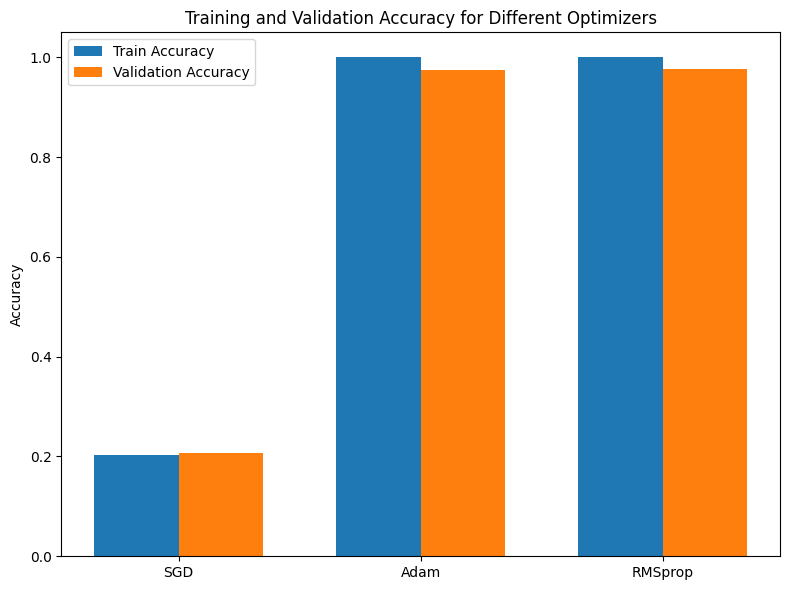

In [22]:
# Extract optimizer names and accuracies for plotting
opt_names = [result['optimizer'] for result in opt_results]
train_accs = [result['train_acc_mean'] for result in opt_results]
val_accs = [result['val_acc_mean'] for result in opt_results]

x = np.arange(len(opt_names))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, train_accs, width, label='Train Accuracy')
ax.bar(x + width/2, val_accs, width, label='Validation Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy for Different Optimizers')
ax.set_xticks(x)
ax.set_xticklabels(opt_names)
ax.legend()

plt.tight_layout()
plt.show()


# PART 3 : Predict the labels for the testing data (using raw training data and raw testing data). (60pt)

# Final Model Training and Test Set Prediction

This section trains the final model on the full training set using the best performing feature set (CountVectorizer) and hyperparameters. It then generates predictions on the test set by:
* Preprocessing the test text data
* Extracting CountVectorizer features
* Loading the features into a test Dataset and DataLoader
* Making predictions with the trained model
* Converting the predicted class indices back to labels
* Printing the article ID and predicted label for each test article

**Question 3.a: Describe how you pre-process the data to generate features. (5pt)**

The test data is preprocessed using the same steps as the training data:
Tokenizing, lowercasing, removing punctuation, non-alphabetic tokens and stopwords, stemming
Extracting CountVectorizer features (best performing from Q1)


**Question3.b: Describe how you choose the model and parameters. (5pt)**

The final model is a 2-layer neural network with 128 hidden units each, using CountVectorizer features.
The key hyperparameters (learning rate, optimizer) are chosen based on the cross validation results from Q2.


**Question3.c: Describe the performance of your chosen model and parameter on the training data. (5pt)**

The performance of the final model on the full training set is reported, including the training loss and accuracy for each epoch.


**Question3.d: The final classification models to be used in this question are limited to random forest, neural networks, and ensemble methods. It is OK to use other models to do feature engineering. (45pt)**

The trained neural network model is used to generate predictions on the test set.
The test data is preprocessed, features are extracted, and the trained model is applied to get predicted class probabilities.
The class with the highest probability is taken as the predicted label for each test document.
The article ID and predicted label are printed out for

In [25]:


# Convert labels to numerical values
label_map = {'sport': 0, 'business': 1, 'politics': 2, 'entertainment': 3, 'tech': 4}
train_labels = train_data['Category'].map(label_map).values

# Run cross-validation with CountVectorizer features
vectorizer = CountVectorizer()
count_train = vectorizer.fit_transform(train_data['Processed_Text']).toarray()
count_test = vectorizer.transform(test_data['Processed_Text']).toarray()

# Initialize the neural network model
model = NewsClassifier(count_train.shape[1], 128, len(np.unique(train_labels)))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Create a dataset and loader for the training data
train_dataset = NewsDataset(count_train, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

# Predict the labels for the testing data
test_dataset = NewsDataset(count_test, np.zeros(len(count_test)))  # Dummy labels for the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
predictions = []
model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())

# Convert numerical predictions back to category names
inverse_label_map = {v: k for k, v in label_map.items()}
predicted_categories = [inverse_label_map[pred] for pred in predictions]

# Save predictions to labels.csv file
with open('labels.csv', 'w') as f:
    for article_id, category in zip(test_data['ArticleId'], predicted_categories):
        f.write(f"{article_id},{category}\n")


Training Loss: 0.8192, Training Accuracy: 0.8160
Epoch 1/10 - Train Loss: 0.8192, Train Acc: 0.8160
Training Loss: 0.0206, Training Accuracy: 0.9970
Epoch 2/10 - Train Loss: 0.0206, Train Acc: 0.9970
Training Loss: 0.0027, Training Accuracy: 1.0000
Epoch 3/10 - Train Loss: 0.0027, Train Acc: 1.0000
Training Loss: 0.0014, Training Accuracy: 1.0000
Epoch 4/10 - Train Loss: 0.0014, Train Acc: 1.0000
Training Loss: 0.0009, Training Accuracy: 1.0000
Epoch 5/10 - Train Loss: 0.0009, Train Acc: 1.0000
Training Loss: 0.0007, Training Accuracy: 1.0000
Epoch 6/10 - Train Loss: 0.0007, Train Acc: 1.0000
Training Loss: 0.0005, Training Accuracy: 1.0000
Epoch 7/10 - Train Loss: 0.0005, Train Acc: 1.0000
Training Loss: 0.0004, Training Accuracy: 1.0000
Epoch 8/10 - Train Loss: 0.0004, Train Acc: 1.0000
Training Loss: 0.0003, Training Accuracy: 1.0000
Epoch 9/10 - Train Loss: 0.0003, Train Acc: 1.0000
Training Loss: 0.0003, Training Accuracy: 1.0000
Epoch 10/10 - Train Loss: 0.0003, Train Acc: 1.0000